### Imports

In [1]:
import html
import re

import numpy as np
import pandas as pd

import nltk
from nltk import word_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize
from nltk.corpus import wordnet
from nltk.corpus import stopwords

import gensim
from gensim.models import Phrases
from gensim.models.phrases import Phraser
from gensim.models import word2vec, KeyedVectors
from gensim import corpora

import networkx as nx

from sklearn.metrics.pairwise import cosine_similarity

# libraries for visualization
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")

### Reading the data 

In [4]:
electronics_path = "dataset/amazon_reviews_us_Electronics_v1_00.tsv"
mobile_elec_path = "dataset/amazon_reviews_us_Mobile_Electronics_v1_00.tsv"

e_reviews = pd.read_csv(electronics_path, sep='\t', error_bad_lines=False)
e_reviews.dropna(inplace=True)

reviews = pd.read_csv(mobile_elec_path, sep='\t', error_bad_lines=False)
reviews.dropna(inplace=True)

b'Skipping line 9076: expected 15 fields, saw 22\nSkipping line 19256: expected 15 fields, saw 22\nSkipping line 24313: expected 15 fields, saw 22\nSkipping line 47211: expected 15 fields, saw 22\nSkipping line 54295: expected 15 fields, saw 22\nSkipping line 56641: expected 15 fields, saw 22\nSkipping line 63067: expected 15 fields, saw 22\n'
b'Skipping line 93796: expected 15 fields, saw 22\n'
b'Skipping line 132806: expected 15 fields, saw 22\nSkipping line 164631: expected 15 fields, saw 22\nSkipping line 167019: expected 15 fields, saw 22\nSkipping line 167212: expected 15 fields, saw 22\n'
b'Skipping line 198103: expected 15 fields, saw 22\nSkipping line 199191: expected 15 fields, saw 22\nSkipping line 202841: expected 15 fields, saw 22\nSkipping line 218228: expected 15 fields, saw 22\nSkipping line 235900: expected 15 fields, saw 22\n'
b'Skipping line 277761: expected 15 fields, saw 22\nSkipping line 304582: expected 15 fields, saw 22\nSkipping line 312029: expected 15 fields,

In [5]:
reviews.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,20422322,R8MEA6IGAHO0B,B00MC4CED8,217304173,BlackVue DR600GW-PMP,Mobile_Electronics,5.0,0.0,0.0,N,Y,Very Happy!,"As advertised. Everything works perfectly, I'm...",2015-08-31
1,US,40835037,R31LOQ8JGLPRLK,B00OQMFG1Q,137313254,GENSSI GSM / GPS Two Way Smart Phone Car Alarm...,Mobile_Electronics,5.0,0.0,1.0,N,Y,five star,it's great,2015-08-31
2,US,51469641,R2Y0MM9YE6OP3P,B00QERR5CY,82850235,iXCC Multi pack Lightning cable,Mobile_Electronics,5.0,0.0,0.0,N,Y,great cables,These work great and fit my life proof case fo...,2015-08-31
3,US,4332923,RRB9C05HDOD4O,B00QUFTPV4,221169481,abcGoodefg® FBI Covert Acoustic Tube Earpiece ...,Mobile_Electronics,4.0,0.0,0.0,N,Y,Work very well but couldn't get used to not he...,Work very well but couldn't get used to not he...,2015-08-31
4,US,44855305,R26I2RI1GFV8QG,B0067XVNTG,563475445,Generic Car Dashboard Video Camera Vehicle Vid...,Mobile_Electronics,2.0,0.0,0.0,N,Y,Cameras has battery issues,"Be careful with these products, I have bought ...",2015-08-31


In [6]:
e_reviews.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,41409413,R2MTG1GCZLR2DK,B00428R89M,112201306,yoomall 5M Antenna WIFI RP-SMA Female to Male ...,Electronics,5,0,0,N,Y,Five Stars,As described.,2015-08-31
1,US,49668221,R2HBOEM8LE9928,B000068O48,734576678,"Hosa GPM-103 3.5mm TRS to 1/4"" TRS Adaptor",Electronics,5,0,0,N,Y,It works as advertising.,It works as advertising.,2015-08-31
2,US,12338275,R1P4RW1R9FDPEE,B000GGKOG8,614448099,Channel Master Titan 2 Antenna Preamplifier,Electronics,5,1,1,N,Y,Five Stars,Works pissa,2015-08-31
3,US,38487968,R1EBPM82ENI67M,B000NU4OTA,72265257,LIMTECH Wall charger + USB Hotsync & Charging ...,Electronics,1,0,0,N,Y,One Star,Did not work at all.,2015-08-31
4,US,23732619,R372S58V6D11AT,B00JOQIO6S,308169188,Skullcandy Air Raid Portable Bluetooth Speaker,Electronics,5,1,1,N,Y,Overall pleased with the item,Works well. Bass is somewhat lacking but is pr...,2015-08-31


In [7]:
reviews.describe()

,customer_id,product_parent,star_rating,helpful_votes,total_votes
count,1.048470e+05,1.048470e+05,104847.000000,104847.000000,104847.000000
mean,2.793730e+07,5.015301e+08,3.763160,1.244032,1.615440
std,1.508714e+07,2.871676e+08,1.523537,7.070485,7.910005
min,1.007100e+04,5.352400e+04,1.000000,0.000000,0.000000
25%,1.471380e+07,2.593731e+08,3.000000,0.000000,0.000000
50%,2.650319e+07,4.939016e+08,4.000000,0.000000,0.000000
75%,4.223490e+07,7.440083e+08,5.000000,1.000000,1.000000
max,5.309657e+07,9.999508e+08,5.000000,769.000000,791.000000


In [8]:
e_reviews.describe()

,customer_id,product_parent,star_rating,helpful_votes,total_votes
count,3.090877e+06,3.090877e+06,3.090877e+06,3.090877e+06,3.090877e+06
mean,2.879218e+07,5.102047e+08,4.035425e+00,1.860723e+00,2.372270e+00
std,1.542970e+07,2.868325e+08,1.387452e+00,2.133747e+01,2.249734e+01
min,1.000500e+04,6.478000e+03,1.000000e+00,0.000000e+00,0.000000e+00
25%,1.503906e+07,2.623618e+08,3.000000e+00,0.000000e+00,0.000000e+00
50%,2.806696e+07,5.085523e+08,5.000000e+00,0.000000e+00,0.000000e+00
75%,4.328140e+07,7.632433e+08,5.000000e+00,1.000000e+00,1.000000e+00
max,5.309658e+07,9.999982e+08,5.000000e+00,1.278600e+04,1.294400e+04


In [9]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 104847 entries, 0 to 104851
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   marketplace        104847 non-null  object 
 1   customer_id        104847 non-null  int64  
 2   review_id          104847 non-null  object 
 3   product_id         104847 non-null  object 
 4   product_parent     104847 non-null  int64  
 5   product_title      104847 non-null  object 
 6   product_category   104847 non-null  object 
 7   star_rating        104847 non-null  float64
 8   helpful_votes      104847 non-null  float64
 9   total_votes        104847 non-null  float64
 10  vine               104847 non-null  object 
 11  verified_purchase  104847 non-null  object 
 12  review_headline    104847 non-null  object 
 13  review_body        104847 non-null  object 
 14  review_date        104847 non-null  object 
dtypes: float64(3), int64(2), object(10)
memory usage: 1

In [10]:
e_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3090877 entries, 0 to 3091023
Data columns (total 15 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   marketplace        object
 1   customer_id        int64 
 2   review_id          object
 3   product_id         object
 4   product_parent     int64 
 5   product_title      object
 6   product_category   object
 7   star_rating        int64 
 8   helpful_votes      int64 
 9   total_votes        int64 
 10  vine               object
 11  verified_purchase  object
 12  review_headline    object
 13  review_body        object
 14  review_date        object
dtypes: int64(5), object(10)
memory usage: 377.3+ MB


### Filter Highly Reviewed Product 

In [11]:
rev_counts = reviews.groupby('product_id')['product_id'].count().sort_values()

In [12]:
rev_counts

product_id
B0072NU65M       1
B009LEK8N0       1
B009LEBDY8       1
B009L4PKO2       1
B009L4LH58       1
              ... 
B005S1CYO6     599
B00E5PI594     615
B002D4IHYM     690
B004911E9M     730
B00J46XO9U    1078
Name: product_id, Length: 25785, dtype: int64

In [13]:
rev_counts[rev_counts > 25]

product_id
B005E95WGE      26
B00TQYCU0Y      26
B0031C9TQU      26
B006MPZ9VC      26
B008GQ09JW      26
              ... 
B005S1CYO6     599
B00E5PI594     615
B002D4IHYM     690
B004911E9M     730
B00J46XO9U    1078
Name: product_id, Length: 543, dtype: int64

In [14]:
e_rev_counts = e_reviews.groupby('product_id')['product_id'].count().sort_values()

In [15]:
e_rev_counts

product_id
0141186178        1
B00839W8FK        1
B0083946DC        1
B00838YTTY        1
B00838LBVS        1
              ...  
B0001FTVEK     8792
B0012S4APK     9358
B003EM8008     9766
B0002L5R78    11166
B003L1ZYYM    15334
Name: product_id, Length: 185766, dtype: int64

In [16]:
target_df = e_reviews[e_reviews.product_id == "B003L1ZYYM"]

In [17]:
target_df.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
59,US,7260378,R9XIRRPMX4Q64,B003L1ZYYM,617978254,AmazonBasics High-Speed HDMI Cable - 6.5 Feet ...,Electronics,5,0,0,N,Y,Five Stars,Does the job.,2015-08-31
536,US,299324,R2KDP8J74TBHVI,B003L1ZYYM,617978254,AmazonBasics High-Speed HDMI Cable - 6.5 Feet ...,Electronics,5,0,0,N,Y,Five Stars,Cool,2015-08-31
537,US,2123151,R3GXS6U70I7CSG,B003L1ZYYM,617978254,AmazonBasics High-Speed HDMI Cable - 6.5 Feet ...,Electronics,5,0,0,N,Y,Five Stars,They work fine.,2015-08-31
570,US,6065426,R1UNCZKKMCUY6I,B003L1ZYYM,617978254,AmazonBasics High-Speed HDMI Cable - 6.5 Feet ...,Electronics,5,0,0,N,Y,Five Stars,I love it,2015-08-31
698,US,17921566,R3NQE9CK9DVXH8,B003L1ZYYM,617978254,AmazonBasics High-Speed HDMI Cable - 6.5 Feet ...,Electronics,5,0,0,N,Y,Five Stars,"Buenas, excelente cable.",2015-08-31


# Remove Fake Reviews 

In [83]:
target_df.shape

(15334, 16)

In [84]:
fake_authors = pd.read_csv('dataset/same_authors.csv')

In [85]:
target_df[~target_df.customer_id.isin(list(fake_authors['customer_id']))].shape

(15331, 16)

In [89]:
target_df = target_df[~target_df.customer_id.isin(list(fake_authors['customer_id']))]

# Pick Latest Reviews 

In [18]:
target_df['review_date'] = pd.to_datetime(target_df['review_date'])

In [19]:
target_df['YearMonth'] = target_df['review_date'] - pd.offsets.MonthBegin(1)
rev_history = target_df.groupby('YearMonth')['review_body'].count()

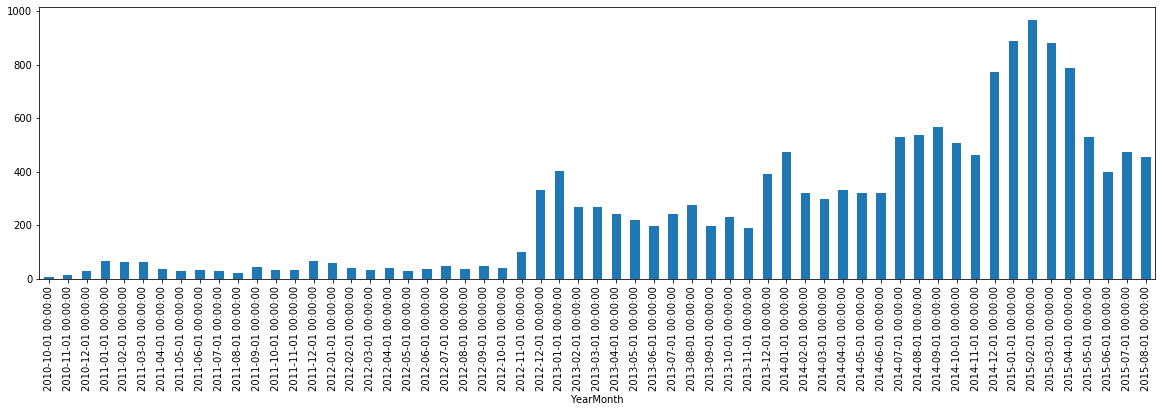

In [20]:
rev_history.plot(kind='bar', figsize=(20,5))

In [21]:
import datetime
latest_df = target_df[target_df.review_date > datetime.datetime(2015, 6, 1)]

In [87]:
len(latest_df)

1328

In [88]:
latest_df.to_csv('dataset/electronics_high_reviews_latest.csv')

In [24]:
def print_reviews(df, row_name):
    for each in df.iterrows():
        print(each[0], each[1][row_name])

In [25]:
print_reviews(latest_df, 'review_body')

59 Does the job.
536 Cool
537 They work fine.
570 I love it
698 Buenas, excelente cable.
920 Good
966 Good buy
1022 Works great.  Prompt delivery, no issues.
1395 excellent cable
1576 Great
1623 as described
1631 Great deal. Good product.
1944 Bought as a replacement HDMI cable.  The Local electronics store was way over priced, this cable is of good quality, and was in an exceptable price.
1992 Great cable. Does what its supposed to do without problems.
1994 Just as good as any other HDMI cable out there! It's a basic HDMI cable and I've yet to see any real world evidence that a more expensive cable somehow does more than any old well built cable.
2058 They are great
2196 Great Cables, Anything 25 feet or less works fine when transporting the HDMI signal. The more expensive cables transport no better signal then the cheaper ones.
2687 what can i say it works
2954 It works great and fast! good price too! if you are looking for a cheap HDMI cable that would last, i would suggest this lit

149972 these use to be $2.00, why the price increase? other than that works great
150014 great
150074 GREAT PRICE BUT THE ENDS ARE NOT GOLD PLATED .  DON'T LET THE PICTURE DECEIVE YOU LIKE IT DID ME.  HOWEVER IT WORKS VERY WELL AND I WOULD CONSIDER PURCHASING AGAIN.
150290 Does the job.
150418 Good item, it wasn't a waste of money.
150463 Works great. Glad I did not pay the big bucks for one of the over-hyped cables.
151861 Amazon makes great cables
151895 Picked up a Roku 2 for the father in law for Father's Day and knew I would need an HDMI cable to hook it up for him.  This fit the bill perfectly and worked great.  Great value HDMI cable.
152427 Good product
152744 Cable works very well.
152869 Works just as well as more expensive brands.
153622 Good price for a great product!
154148 It works very well with my AV to HDMI converter.
154239 excelente
154268 Excelent product
154325 These cables work perfect and the price is amazing
154929 This cable works perfectly, and feels pretty hi

265398 works as it should
265694 Very high quality cable. Much better quality and vaule when compared to Best Buy crap that they try to sell. Will buy again if I ever need more cables.
265756 Id look for a different brand... Though these are cheap, they don't last long. Had mine for maybe 4 months before they had choppy connection.
265781 It is a perfectly functional, basic HDMI cable at a low price. Certainly adequate for 40&#34; and under displays (largest I have used with these), probably fine above that. I'll get more in all available lengths.
265878 I keep this in my laptop bag for times when I need to connect my computer to a television.  This works very well, is plenty long enough, but easy to carry around!
266137 I am so happy with this.  I can watch stuff from my laptop on my tv.  I have a Samsung Chromebook and it works great.
266374 Good deal.
266639 Good for the price.
266649 Obviously, I purchased this cable because I needed one.  Upon receipt, it was exactly what was desc

### Preprocess 

In [90]:
# https://www.machinelearningplus.com/nlp/lemmatization-examples-python/
# https://stackoverflow.com/questions/25534214/nltk-wordnet-lemmatizer-shouldnt-it-lemmatize-all-inflections-of-a-word

# Remove HTML tags like <br/>
HTML_TAG_RE = re.compile(r'<[^>]+>')

# Remove punctuations
PUNCT_RE = re.compile(r"['|\"]")

# Include only words and spaces without any special characters.
WORD_SPACE_PATTERN = r"[^\w\s]"

# Replace any extra spaces with a single space.
NUMBER_PATTERN = r"[0-9]+"

# Replace any extra spaces with a single space.
EXTRA_SPACE_PATTERN = r"[\s]+"

# Initializing stopwords and removing special characters from stopwords:
stop_words = stopwords.words("english")
stop_words = [word.replace("\'", "") for word in stop_words]

# Create Lemmatizer:
lemma = WordNetLemmatizer()

def lemmatize_and_clean(tagged_token, include_stopwords):
    cleaned = []
    for token in tagged_token:
        word = token[0]
        
        # Exclude the stop words:
        if not include_stopwords:
            if word in stop_words:
                continue
        
        # Convert to lemma based on the parts of speech:
        tag = token[1][0]
        if tag.startswith('J'):
            cleaned.append(lemma.lemmatize(word, wordnet.ADJ))
        elif tag.startswith('V'):
            cleaned.append(lemma.lemmatize(word, wordnet.VERB))
        elif tag.startswith('N'):
            cleaned.append(lemma.lemmatize(word, wordnet.NOUN))
        elif tag.startswith('R'):
            cleaned.append(lemma.lemmatize(word, wordnet.ADV))
        else:          
            cleaned.append(word)
            
    return cleaned

def nltk_transform(document, include_stopwords):
    lemmatized_list = []
    tokenized_sent = sent_tokenize(document)
    for sentence in tokenized_sent:
        no_punctuation = re.sub(r"[`'\",.!?()]", "", sentence)
        tokenized_word = word_tokenize(no_punctuation)
        tagged_token = pos_tag(tokenized_word)
        lemmatized = lemmatize_and_clean(tagged_token, include_stopwords)
        lemmatized_list.extend(lemmatized)
    return " ".join(lemmatized_list)


def clean(text, include_stopwords=False):
    processed = html.unescape(text)
    processed = re.sub(HTML_TAG_RE, " ", processed)
    processed = re.sub(PUNCT_RE, '', processed)
    processed = nltk_transform(processed, include_stopwords)
    processed = processed.lower()
    processed = re.sub(WORD_SPACE_PATTERN, " ", processed)
    processed = re.sub(NUMBER_PATTERN, " ", processed)
    processed = re.sub(EXTRA_SPACE_PATTERN, " ", processed)
    processed = processed.strip()
    return processed

In [27]:
latest_df["preprocessed"] = latest_df["review_body"].apply(lambda row: clean(row))

In [28]:
print_reviews(latest_df, 'preprocessed')

59 does job
536 cool
537 they work fine
570 i love
698 buenas excelente cable
920 good
966 good buy
1022 works great prompt delivery issue
1395 excellent cable
1576 great
1623 described
1631 great deal good product
1944 bought replacement hdmi cable the local electronics store way price cable good quality exceptable price
1992 great cable does suppose without problem
1994 just good hdmi cable its basic hdmi cable ive yet see real world evidence expensive cable somehow old well build cable
2058 they great
2196 great cables anything foot less work fine transport hdmi signal the expensive cable transport good signal cheap one
2687 say work
2954 it work great fast good price look cheap hdmi cable would last would suggest little guy
3127 great cable no need spend buck hdmi cable big box store
3184 cheap work well apple tv tivo roku connect samsung tv quality image without fail
3366 perfect
4123 best buy suck
4327 item work plan ship good time have problem item would recommend seller anyone


174639 work great great price
174711 nice
174717 maybe work someone else i buy order help purple line giggle bottom tv screen work
175126 great
175204 ok
175237 i need extra cable work great
175300 great
175522 works
175600 very good need
176229 its hdmi cable it work connect computer tv
176463 perfect
177303 ordered get faulty amazon exchange free cost working fine good choice cost
177428 top qualitygreat price
177582 good expensive item
177670 excellent
177767 fast shipping excellent product thanks
177965 good hdmi cable not much else say
179306 does job
179432 this work expect it appear make good quality arrive timely fashion promised
179805 work
180218 great quality excellent signal apple tv
180282 work great
180515 good
180707 good hdmi i year still work
180993 ok
181124 just need
181203 i use connect monitor laptop it work perfectly seem much well build hdmi chord perfect chord ft length help whole lot there absolutely nothing well anywhere electronic store online shop ebay amazo

## Train Word Embeddings 

### Tokenize 

Train the embeddings on the whole dataset

In [239]:
reviews['preprocessed'] = reviews['review_body'].apply(lambda row: clean(row))

In [93]:
corpora = reviews["preprocessed"].values

# Split the reviews into words
tokenized = [corpus.split(" ") for corpus in corpora]

# Generate Bi and Tri grams:
# bi_gram = Phrases(tokenized, min_count=5, threshold=1)
# tri_gram = Phrases(bi_gram[tokenized], min_count=5, threshold=1)

# # Include bi_grams and tri_grams in the tokenized set:
# tokenized = [Phraser(tri_gram)[Phraser(bi_gram)[i]] for i in tokenized]

In [94]:
tokenized[0]

['as',
 'advertised',
 'everything',
 'work',
 'perfectly',
 'im',
 'happy',
 'camera',
 'as',
 'matter',
 'fact',
 'im',
 'go',
 'buy',
 'another',
 'one',
 'nd',
 'car']

In [27]:
%%time
# 300 Features:
word_vec= word2vec.Word2Vec(tokenized, 
                            size=300,
                            window=5, 
                            min_count=1,
                            iter=50, 
                            seed=42)

CPU times: user 6min 18s, sys: 1.12 s, total: 6min 19s
Wall time: 2min 8s


In [28]:
# Unpack the embeddings into a dataframe:
word_vec_unpack = [(word, idx.index) for word, idx in word_vec.wv.vocab.items()]
tokens, indexes = zip(*word_vec_unpack)
word_vec_df = pd.DataFrame(word_vec.wv.vectors, index=tokens)
display(word_vec_df.head())

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
as,-1.235333,-0.468444,-1.499942,0.117953,-1.625123,0.388569,0.894040,-1.013722,0.729220,0.297348,...,-0.710567,-0.885529,0.376027,-0.666393,0.234028,0.449359,0.545860,-0.503153,-1.216799,-0.944759
advertised,-0.967268,0.382194,0.575323,1.227980,-0.464519,-0.135717,-1.055957,-0.091994,-2.064932,-1.560730,...,-0.290816,0.172058,0.898717,0.088537,-0.250208,0.057940,-0.216181,-0.316466,-0.176364,1.291554
everything,-0.247303,0.269724,0.212065,0.499858,-0.688725,0.810532,1.436355,-1.932259,-1.585469,-0.158601,...,-0.588933,-1.051700,0.891962,0.980796,0.580919,-1.237316,-0.369542,0.331872,-1.747416,-0.812227
work,-0.844025,0.061232,-0.132879,-0.494827,0.035805,-0.093060,0.389451,1.013285,-0.687152,0.790693,...,-0.265650,-0.479708,0.696546,0.375808,-0.332863,1.526522,0.798353,0.221732,-1.079167,-0.028466
perfectly,0.270758,-0.733486,-0.285694,1.537664,-1.193052,-0.675084,0.852766,-0.059312,0.091238,0.652778,...,-0.108888,-0.324359,-0.538062,-0.387401,0.499417,-0.423852,1.428874,0.090356,-0.685006,-1.614477


In [29]:
len(word_vec_df)

56647

In [95]:
%%time
# 100 Features
word_vec_100 = word2vec.Word2Vec(tokenized, 
                            size=100,
                            window=5, 
                            min_count=1,
                            iter=50, 
                            seed=42)

CPU times: user 4min 29s, sys: 1.04 s, total: 4min 30s
Wall time: 1min 31s


In [56]:
# Unpack the embeddings into a dataframe:
word_vec_unpack_100 = [(word, idx.index) for word, idx in word_vec_100.wv.vocab.items()]
tokens_100, indexes_100 = zip(*word_vec_unpack_100)
word_vec_df_100 = pd.DataFrame(word_vec_100.wv.vectors, index=tokens)
display(word_vec_df_100.head())

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
as,-1.329843,-1.023304,-0.705308,-1.408986,-3.496535,2.563459,0.106454,-1.055815,0.313600,-0.710187,...,-0.811009,-0.936035,-0.973735,0.392726,-0.300826,-0.702857,0.065253,-1.184279,-1.324672,1.344303
advertised,-0.254256,1.449856,0.074953,1.872956,-1.714400,1.936150,0.824661,-1.069778,-2.929671,-2.610348,...,-1.664341,-0.969798,-0.905035,0.392293,0.304974,1.349671,-1.567328,0.703329,1.467231,1.104921
everything,-1.636014,1.794731,1.263910,-0.287241,-1.327355,-1.006870,0.767725,-1.693072,-2.771437,1.627638,...,-0.095814,2.115452,-1.679875,2.257799,0.495756,-0.448224,-1.428461,0.346203,0.168022,-0.442132
work,-0.737792,0.844641,-0.957993,0.894790,-0.099020,0.461457,2.209008,1.533988,0.775550,-1.197040,...,-2.851125,-0.701641,-1.622961,2.761444,-2.312141,1.445785,-2.189960,0.350316,1.339608,-0.300108
perfectly,-2.160525,-1.648286,-0.266225,1.453353,-1.980416,-0.559069,1.811338,1.066400,0.317917,0.261954,...,-2.096253,-1.591354,-2.248039,-0.900149,0.366020,2.522064,-1.028599,-0.848615,-1.400615,-1.001657


In [30]:
we_filename = 'dataset/GoogleNews-vectors-negative300.bin'
we_model = KeyedVectors.load_word2vec_format(we_filename, binary=True)

## Topic Modeling 

In [99]:
dictionary = corpora.Dictionary(tokenized)
doc_term_matrix = [dictionary.doc2bow(rev) for rev in tokenized]

In [140]:
doc_term_matrix[0]

[(0, 1),
 (1, 1),
 (2, 2),
 (3, 1),
 (4, 1),
 (5, 1),
 (6, 1),
 (7, 1),
 (8, 1),
 (9, 1),
 (10, 2),
 (11, 1),
 (12, 1),
 (13, 1),
 (14, 1),
 (15, 1)]

#### All Reviews 

In [36]:
LDA = gensim.models.ldamodel.LdaModel

In [100]:
lda_model = LDA(corpus=doc_term_matrix, 
                id2word=dictionary, 
                num_topics=2, 
                random_state=100,
                chunksize=1000, 
                passes=50)

In [102]:
lda_model.print_topics()

[(0,
  '0.057*"i" + 0.025*"case" + 0.018*"the" + 0.016*"ipod" + 0.012*"screen" + 0.012*"it" + 0.011*"great" + 0.010*"fit" + 0.010*"product" + 0.010*"get"'),
 (1,
  '0.050*"i" + 0.013*"the" + 0.012*"use" + 0.011*"work" + 0.009*"get" + 0.008*"one" + 0.007*"player" + 0.007*"good" + 0.006*"sound" + 0.006*"unit"')]

#### Target Product Reviews 

In [31]:
latest_df['preprocessed'] = latest_df['review_body'].apply(lambda row: clean(row))
latest_corpora = latest_df["preprocessed"].values
latest_tokenized = [corpus.split(" ") for corpus in latest_corpora]
latest_dictionary = corpora.Dictionary(latest_tokenized)
latest_doc_term_matrix = [latest_dictionary.doc2bow(rev) for rev in latest_tokenized]

In [33]:
latest_tokenized[0]

['does', 'job']

In [34]:
latest_doc_term_matrix[0]

[(0, 1), (1, 1)]

In [37]:
%%time
latest_lda_model = LDA(corpus=latest_doc_term_matrix, 
                       id2word=latest_dictionary, 
                       num_topics=2, 
                       random_state=100,
                       chunksize=1000, 
                       passes=50)

CPU times: user 12.3 s, sys: 35.8 ms, total: 12.4 s
Wall time: 12.4 s


In [39]:
latest_lda_model.print_topics()

[(0,
  '0.056*"work" + 0.056*"great" + 0.033*"works" + 0.030*"i" + 0.029*"cable" + 0.026*"tv" + 0.020*"well" + 0.015*"price" + 0.015*"it" + 0.013*"use"'),
 (1,
  '0.058*"cable" + 0.048*"good" + 0.036*"i" + 0.029*"quality" + 0.027*"price" + 0.026*"hdmi" + 0.025*"product" + 0.018*"buy" + 0.016*"great" + 0.012*"excellent"')]

In [40]:
topic_1_reviews = []
topic_2_reviews = []
for i, idx in enumerate(latest_df.index):
    perc = latest_lda_model[latest_doc_term_matrix[i]]
    # If second topic is of more:
    if len(perc) == 2:
        if perc[1][1] < perc[0][1]:
            topic_1_reviews.append(idx)
        else:
            topic_2_reviews.append(idx)
    elif len(perc) == 1:
        if perc[0][0] == 0:
            topic_1_reviews.append(idx)
        else:
            topic_2_reviews.append(idx)

In [41]:
len(topic_2_reviews) / len(latest_df) * 100

49.096385542168676

In [42]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(latest_lda_model, latest_doc_term_matrix, latest_dictionary)
vis

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
1      0.137804  0.0       1        1  51.314270
0     -0.137804  0.0       2        1  48.685726, topic_info=        Term        Freq       Total Category  logprob  loglift
5       work  275.000000  275.000000  Default  30.0000  30.0000
11      good  247.000000  247.000000  Default  29.0000  29.0000
17     works  161.000000  161.000000  Default  28.0000  28.0000
80        tv  125.000000  125.000000  Default  27.0000  27.0000
28   quality  153.000000  153.000000  Default  26.0000  26.0000
..       ...         ...         ...      ...      ...      ...
27     price   72.963066  211.006775   Topic2  -4.1936  -0.3422
112     this   31.568140   62.814209   Topic2  -5.0314   0.0318
25      hdmi   35.234936  165.715530   Topic2  -4.9215  -0.8285
404      get   25.576675   51.631245   Topic2  -5.2419   0.0173
180     high   23.601328   50.143227   Topic2  -5.3222  -0.0338

[123 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
92        1  0.974117           a
92        2  0.044278           a
236       1  0.958068  advertised
236       2  0.059879  advertised
93        1  0.982873      always
...     ...       ...         ...
17        2  0.994508       works
303       1  0.995568       worth
303       2  0.058563       worth
203       1  0.054934        year
203       2  0.988805        year

[158 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

## Text Summarization 

In [44]:
# word_embeddings = word_vec_df.T.to_dict('list')
# word_embeddings = word_vec_df_100.T.to_dict('list')

def get_sent_vecs(data):
    sentences = []
    for s in data['preprocessed']:
        sentences.append(sent_tokenize(s))
    sentences = [y for x in sentences for y in x]

    sentence_vectors = []
    for i in sentences:
        if len(i) != 0:
            # v = sum([np.array(word_embeddings.get(w, np.zeros((100,)))) for w in i.split()]) / (len(i.split()) + 0.001)
            for w in i.split():
                embs = we_model[i] if i in we_model else np.zeros((300, ))
                v = sum([embs for w in i.split()]) / (len(i.split()) + 0.001)
        else:
            v = np.zeros((300,))
        sentence_vectors.append(v)
        
    return sentences, sentence_vectors

In [51]:
latest_df.to_csv('dataset/electronics_latest_revs_before_senti.csv')

In [56]:
senti_revs = pd.read_csv('dataset/electronics_latest_revs_after_senti.csv')

In [91]:
positive = senti_revs[senti_revs.sentiment == 'Positive']
negative = senti_revs[senti_revs.sentiment == 'Negative']

positive['preprocessed'] = positive['review_body'].apply(lambda row: clean(row, include_stopwords=True))
negative['preprocessed'] = negative['review_body'].apply(lambda row: clean(row, include_stopwords=True))

In [60]:
cond = latest_df.review_body.str.len() > 100
sentences, sent_vecs = get_sent_vecs(latest_df[cond])

In [92]:
pos_sentences, pos_sent_vecs = get_sent_vecs(positive[positive.review_body.str.len() > 100])
neg_sentences, neg_sent_vecs = get_sent_vecs(negative[negative.review_body.str.len() > 100])

In [93]:
sim_mat = np.zeros([len(sent_vecs), len(sent_vecs)])
pos_sim_mat = np.zeros([len(pos_sent_vecs), len(pos_sent_vecs)])
neg_sim_mat = np.zeros([len(neg_sent_vecs), len(neg_sent_vecs)])

In [94]:
def get_sim_mat(sent_vecs):
    sim_mat = np.zeros([len(sent_vecs), len(sent_vecs)])
    for i in range(len(sent_vecs)):
        for j in range(len(sent_vecs)):
            if i != j:
                sim_mat[i][j] = cosine_similarity(sent_vecs[i].reshape(1, 300), sent_vecs[j].reshape(1, 300))[0,0]
    return sim_mat
                
sim_mat = get_sim_mat(sent_vecs)
pos_sim_mat = get_sim_mat(pos_sent_vecs)
neg_sim_mat = get_sim_mat(neg_sent_vecs)

In [95]:
%%time
nx_graph = nx.from_numpy_array(sim_mat)
scores = nx.pagerank(nx_graph, max_iter=100)

ranked_sentences = sorted(((scores[i], s) for i,s in enumerate(sentences)), reverse=True)

CPU times: user 5.92 ms, sys: 2.13 ms, total: 8.05 ms
Wall time: 7.25 ms


In [96]:
pos_nx_graph = nx.from_numpy_array(pos_sim_mat)
neg_nx_graph = nx.from_numpy_array(neg_sim_mat)

pos_scores = nx.pagerank(pos_nx_graph, max_iter=100)
neg_scores = nx.pagerank(neg_nx_graph, max_iter=100)

pos_ranked_sentences = sorted(((pos_scores[i], s) for i,s in enumerate(pos_sentences)), reverse=True)
neg_ranked_sentences = sorted(((neg_scores[i], s) for i,s in enumerate(neg_sentences)), reverse=True)

In [102]:
# Specify number of sentences to form the summary
sn = 5

# Generate summary
print("Positive Review Summary")
for i in range(sn):
    print(pos_ranked_sentences[i][1])
    

print("\nNegative Review Summary")
for i in range(sn):
    print(neg_ranked_sentences[i][1])

Positive Review Summary
you honestly cant beat the price of these cable they be truly worth every penny i have personally test them against the expensive hdmi cable from best buy and cant tell any difference in picture quality at all
you can not beat the value here it be every bit as good as advertised and have make it my goto recommendation for friendsfamilycoworkers
work well to connect my bluray player to the television the picture quality be great exceptional value
work well but i dont think its that much different than the cheap onesthe look and feel be of the more expensive cord
work very welli use this cable to connect my ipad to my tv and the resolution on the tv be excellent

Negative Review Summary
yup its an hdmi cable it be no ferrite ring but seem to handle xbox through aled tv just fine i buy this because i didnt think my new monitor have one with it when it do i just use it for my pc and this one for xbox
work well but i accidentally buy the wrong length i buy thefoot on

In [100]:
latest_df.iloc[683]

marketplace                                                         US
customer_id                                                   47039998
review_id                                               R1K064YHEYAI6V
product_id                                                  B003L1ZYYM
product_parent                                               617978254
product_title        AmazonBasics High-Speed HDMI Cable - 6.5 Feet ...
product_category                                           Electronics
star_rating                                                          5
helpful_votes                                                        0
total_votes                                                          0
vine                                                                 N
verified_purchase                                                    Y
review_headline                                          great service
review_body                         good product, arrived as described
review